In [1]:
import cv2
import os
import glob

# Set the directory where your images are located
image_folder = './'
images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
# images = [img for img in os.listdir(image_folder) if (img.startswith("power") and img.endswith(".png"))]
video_name = 'dense.mp4'

frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'avc1'
video = cv2.VideoWriter(video_name, fourcc, 20, (width, height))

# Sort the file names if necessary
images.sort()  # Sort the images by name (this is optional and may depend on your naming convention)

# Append the images to the video
for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

# Release the video writer
cv2.destroyAllWindows()
video.release()

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo
from astropy.constants import G
import yt

font = {'family': 'serif',
        'weight': 'normal',
        'size': 10,
}

In [2]:
# Constants
G = 6.67430e-11         # Gravitational constant in m^3 kg^-1 s^-2
G *= (100)**3 / 1000 # to cgs
Number_Density_Fraction = 1.16e-24

In [3]:
# Functions

def Virial_Radius( halo_mass, redshift):
    # Example values
    halo_mass = halo_mass * u.g  # Halo mass
    overdensity = 200  # Overdensity factor

    # Calculate critical density of the universe at given redshift
    critical_density = cosmo.critical_density(redshift)

    # Calculate the virial radius
    # M = (4/3) * pi * R_vir^3 * Delta * rho_c
    # Rearranging for R_vir:
    virial_radius = ((3 * halo_mass) / (4 * np.pi * overdensity * critical_density))**(1/3)

    return virial_radius.value

def Mass_Shells( coord, mass, center, num_bins ):
    # Calculate the distance from the center of mass
    dist = np.sqrt( np.sum( (coord - center)**2, axis=1 ) )

    # Calculate the virial radius
    max_radius = max( dist )

    # Calculate the bin edges
    bin_edges = np.linspace( 0, max_radius, num_bins + 1 )

    # Calculate the mass in each shell
    mass_in_shells, bin_edges = np.histogram( dist, bins=bin_edges, weights=mass )

    # Calculate the mass in each shell
    mass_in_shells = mass_in_shells * u.g

    # Calculate the volume of each shell
    shell_volume = (4/3) * np.pi * (bin_edges[1:]**3 - bin_edges[:-1]**3)

    # Calculate the density in each shell
    density_in_shells = mass_in_shells.value / shell_volume

    return density_in_shells, bin_edges

def Center_of_Quan( quan, mass ):
    # Calculate the center of mass
    coq = np.zeros(3)
    for i in range(3):
        coq[i] = np.sum( quan[:,i] * mass ) / np.sum( mass )

    return coq

def Potential( coord, mass ):
    # Calculate the potential energy of the system
    G = 6.67430e-11         # Gravitational constant in m^3 kg^-1 s^-2
    G = G * (100)**3 / 1000 # to cgs

    potential = 0
    for i in range(len(mass)):
        for j in range(i+1, len(mass)):
            r = np.sqrt( np.sum( (coord[i] - coord[j])**2 ) )
            potential += - G * mass[i] * mass[j] / r
    
    return potential

def Density_In_Beams( mass, density, num_bins, to_number_density=False ):

    if to_number_density:
        density_cal = density / Number_Density_Fraction
        bin_edges = np.logspace( -6, 9, num_bins + 1 )
    else:
        density_cal = density
        bin_edges = np.logspace( -30, -13, num_bins + 1 )

    # Calculate the mass in each beams
    density_in_beams, bin_edges = np.histogram( density_cal, bins=bin_edges, weights=mass )
    density_in_beams_fraction = density_in_beams / np.sum(mass)

    return density_in_beams_fraction, bin_edges

In [4]:
N_i = 8
N_f = 159

N_s = 158

In [5]:
f = h5py.File("snapshot_%03d.hdf5" % (N_s), 'r')

scale_factor        = f['Header'].attrs['Time']
h_factor            = f['Header'].attrs['HubbleParam']
unit_length_cgs     = f['Header'].attrs['UnitLength_In_CGS']
unit_mass_cgs       = f['Header'].attrs['UnitMass_In_CGS']
unit_vel_cgs        = f['Header'].attrs['UnitVelocity_In_CGS']

# Calculate the position and the velocity of the center of mass

gas_coord   = f['PartType0']['Coordinates'][:]
gas_vel     = f['PartType0']['Velocities'][:]
gas_mass    = f['PartType0']['Masses'][:]
gas_density = f['PartType0']['Density'][:]

coord   = gas_coord * scale_factor * unit_length_cgs
vel     = gas_vel * np.sqrt(scale_factor) * unit_vel_cgs
mass    = gas_mass * unit_mass_cgs
density = gas_density * unit_mass_cgs / (unit_length_cgs * scale_factor)**3

pos_com = Center_of_Quan( coord, mass )
vel_com = Center_of_Quan( vel, mass )

pos_com, vel_com

(array([-1.75745412e+20, -1.39585706e+19,  5.09256859e+19]),
 array([-41273.77539939, -21056.86238514,  50107.44550577]))

In [33]:
f['PartType0'].keys()

<KeysViewHDF5 ['AGS-Softening', 'Coordinates', 'Density', 'ElectronAbundance', 'InternalEnergy', 'Masses', 'NeutralHydrogenAbundance', 'ParticleChildIDsNumber', 'ParticleIDGenerationNumber', 'ParticleIDs', 'Potential', 'SmoothingLength', 'StarFormationRate', 'Temperature', 'Velocities']>

All snapshots section

In [ ]:
# Calculate the accretion rate
mass_set = []
time_set = []
com_set = []
com_1_set = []

# Calculate the spin parameter
spin_set = []
r_half_set = []

N_i = 30
N_f = 159

for i in range(N_i, N_f):
    # Constants
    G = 6.67430e-11         # Gravitational constant in m^3 kg^-1 s^-2
    G = G * (100)**3 / 1000 # to cgs

    f = h5py.File( "snapshot_%03d.hdf5" % i )

    scale_factor        = f['Header'].attrs['Time']
    h_factor            = f['Header'].attrs['HubbleParam']
    unit_length_cgs     = f['Header'].attrs['UnitLength_In_CGS']
    unit_mass_cgs       = f['Header'].attrs['UnitMass_In_CGS']
    unit_vel_cgs        = f['Header'].attrs['UnitVelocity_In_CGS']

    gas_coord   = f['PartType0']['Coordinates'][:] 
    gas_vel     = f['PartType0']['Velocities'][:]
    gas_mass    = f['PartType0']['Masses'][:]
    gas_density = f['PartType0']['Density'][:]

    coord   = gas_coord * scale_factor * unit_length_cgs
    mass    = gas_mass * unit_mass_cgs
    density = gas_density * unit_mass_cgs / (unit_length_cgs * scale_factor)**3

    time = 1/scale_factor - 1
    ind = np.where( density > 200*cosmo.critical_density(time).value )[0]

    mass_over = mass[ind]
    coord_over = coord[ind]

    # Example particle data (replace with your data)
    x, y, z = coord[:,0], coord[:,1], coord[:,2]

    # Total mass
    M = np.sum(mass)

    # Center of mass
    CM_x = np.sum(x * mass) / M
    CM_y = np.sum(y * mass) / M
    CM_z = np.sum(z * mass) / M

    # Position and velocity relative to center of mass
    rel_x = x - CM_x
    rel_y = y - CM_y
    rel_z = z - CM_z

    # radius within 2.5 ckpc/h
    distance = np.sqrt( rel_x**2 + rel_y**2 + rel_z**2)
    r_offset = 2.5 * scale_factor * unit_length_cgs
    ind = np.where(distance[ind] < r_offset)[0]

    M_in_5 =  mass_over[ind]
    coord_5 = coord_over[ind]

    M = np.sum(M_in_5)

    # Center of mass
    CM_x = np.sum(coord_5[:, 0] * M_in_5) / M
    CM_y = np.sum(coord_5[:, 1] * M_in_5) / M
    CM_z = np.sum(coord_5[:, 2] * M_in_5) / M

    # Position and velocity relative to center of mass
    rel_x = coord[:, 0] - CM_x
    rel_y = coord[:, 1] - CM_y
    rel_z = coord[:, 2] - CM_z

    # radius within 0.2 ckpc/h
    distance = np.sqrt( rel_x**2 + rel_y**2 + rel_z**2)
    r_offset = 0.2 * scale_factor * unit_length_cgs
    ind = np.where(distance < r_offset)[0]

    M_in_1 = np.sum( mass[ind] )

    mass_set.append( M_in_1 )
    time_set.append( 1/scale_factor - 1 )

In [11]:
# calculate the mass accretion rate
mass_set = np.array( mass_set )
time_set = np.array( time_set )
phys_time_set = []
rate = []

phys_time_set.append( cosmo.age(time_set[0]).value * 1e9 )
for i in range(1, len(mass_set)):
    phys_time_set.append( cosmo.age(time_set[i]).value * 1e9 )
    rate.append( (mass_set[i] - mass_set[i-1]) / (phys_time_set[i] - phys_time_set[i-1]) )

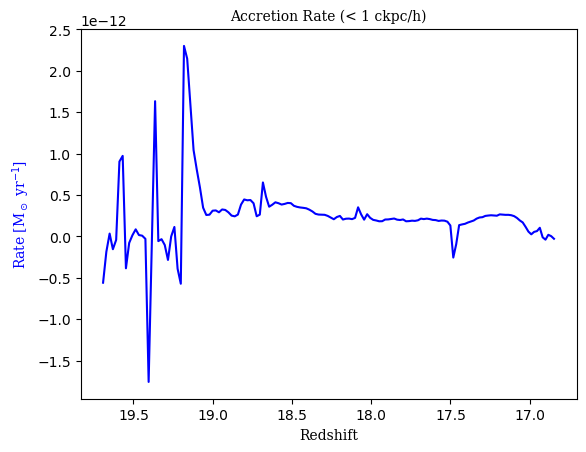

In [12]:
# Plot the accretion rate
fig, ax1 = plt.subplots()

ax1.plot( time_set[1:] , rate / unit_mass_cgs, 'b-' )
ax1.invert_xaxis()

ax1.set_xlabel('Redshift', fontdict=font)
ax1.set_ylabel('Rate [M$_\odot$ yr$^{-1}$]', color='b', fontdict=font)

plt.title('Accretion Rate (< 1 ckpc/h)', fontdict=font)
plt.show()

Single snapshot section

In [6]:
# Calculate the mach number of the specific snapshots

f = h5py.File( "snapshot_%03d.hdf5" % N_s )

scale_factor        = f['Header'].attrs['Time']
h_factor            = f['Header'].attrs['HubbleParam']
unit_length_cgs     = f['Header'].attrs['UnitLength_In_CGS']
unit_mass_cgs       = f['Header'].attrs['UnitMass_In_CGS']
unit_vel_cgs        = f['Header'].attrs['UnitVelocity_In_CGS']
time = 1/scale_factor - 1

# Particle Type 0
gas_coord   = f['PartType0']['Coordinates'][:] 
gas_vel     = f['PartType0']['Velocities'][:]
gas_mass    = f['PartType0']['Masses'][:]
gas_density = f['PartType0']['Density'][:]
gas_potent  = f['PartType0']['Potential'][:]
gas_temp    = f['PartType0']['Temperature'][:]
gas_intern  = f['PartType0']['InternalEnergy'][:]

coord       = gas_coord * scale_factor * unit_length_cgs
mass        = gas_mass * unit_mass_cgs
velocity    = gas_vel * np.sqrt(scale_factor) * unit_vel_cgs
density     = gas_density * unit_mass_cgs / (unit_length_cgs * scale_factor)**3
potential   = gas_potent * unit_vel_cgs**2 / scale_factor

# Particle Type 1
dm_coord    = f['PartType1']['Coordinates'][:] * scale_factor * unit_length_cgs
dm_mass     = f['PartType1']['Masses'][:] * unit_mass_cgs

time = 1/scale_factor - 1

In [22]:
gas_vel, velocity, np.sqrt(scale_factor)

(array([[  2.7613354, -28.568556 ,   8.975918 ],
        [  4.1538258, -27.667877 ,   7.020336 ],
        [  7.1725554, -32.30791  ,  11.698451 ],
        ...,
        [ -9.434362 ,  -6.359802 ,  42.01672  ],
        [ -8.685019 ,  -4.553029 ,  42.468483 ],
        [ -9.186238 ,  -4.959062 ,  44.28385  ]], dtype=float32),
 array([[  65396.945, -676591.56 ,  212577.44 ],
        [  98375.42 , -655260.75 ,  166263.23 ],
        [ 169868.25 , -765151.06 ,  277055.44 ],
        ...,
        [-223434.83 , -150619.75 ,  995085.6  ],
        [-205688.05 , -107829.79 , 1005784.8  ],
        [-217558.48 , -117445.9  , 1048778.4  ]], dtype=float32),
 0.23683087166466055)

In [11]:
ind = np.where( density > 200*cosmo.critical_density(time).value )[0]

# mass_over   = mass[ind]
coord_over  = coord[ind]
# vel_over    = velocity[ind]

# # Example particle data (replace with your data)
# x, y, z = coord[:,0], coord[:,1], coord[:,2]

# # Center of mass of over density area
# CM_x, CM_y, CM_z = Center_of_Quan( coord_over, mass_over )

# # Position and velocity relative to center of mass
# rel_x = coord_over[:, 0] - CM_x
# rel_y = coord_over[:, 1] - CM_y
# rel_z = coord_over[:, 2] - CM_z

# # radius within 2.5 ckpc/h
# distance = np.sqrt( rel_x**2 + rel_y**2 + rel_z**2)
# r_offset = 2.5 * scale_factor * unit_length_cgs
# ind_5 = np.where(distance < r_offset)[0]

# mass_in_5   = mass_over[ind_5]
# coord_in_5  = coord_over[ind_5]

# Center of mass
# CM_x, CM_y, CM_z = Center_of_Quan( coord_in_5, mass_in_5 )

COM = coord[np.argmax(density)]

# Position and velocity relative to center of mass
rel_x = coord[:, 0] - COM[0]
rel_y = coord[:, 1] - COM[1]
rel_z = coord[:, 2] - COM[2]

# radius within 1 ckpc/h
distance = np.sqrt( rel_x**2 + rel_y**2 + rel_z**2)
r_offset = 5 * scale_factor * unit_length_cgs
ind_1 = np.where(distance < r_offset)[0]

coord_in_1  = coord[ind_1]
mass_in_1   = mass[ind_1]
vel_in_1    = velocity[ind_1]

# Assuming you have these arrays from your simulation
# velocities: an Nx3 array containing the velocity vectors of N points
# masses: an optional N array containing the masses of N points (if you want a mass-weighted average)

# Example data - replace this with your actual data
velocities = vel_in_1
masses = mass_in_1 

# Calculate the average velocity
# If you have masses and want to do a mass-weighted average:
total_mass = np.sum(masses)
average_velocity = np.sum(velocities.T * masses, axis=1) / total_mass

# Calculate the velocity fluctuations
velocity_fluctuations = velocities - average_velocity

# If needed, calculate the magnitude of these fluctuations
velocity_fluctuation_magnitudes = np.linalg.norm(velocity_fluctuations, axis=1)

position_data = coord_in_1
velocity_data = vel_in_1

# Calculate the total energy respect to the center of mass
distance = np.logspace(-3, 2, 200)

gas_distance = np.sqrt( np.sum( (gas_coord - COM)**2, axis=1 ) )
dm_distance  = np.sqrt( np.sum( (dm_coord - COM)**2, axis=1 ) )

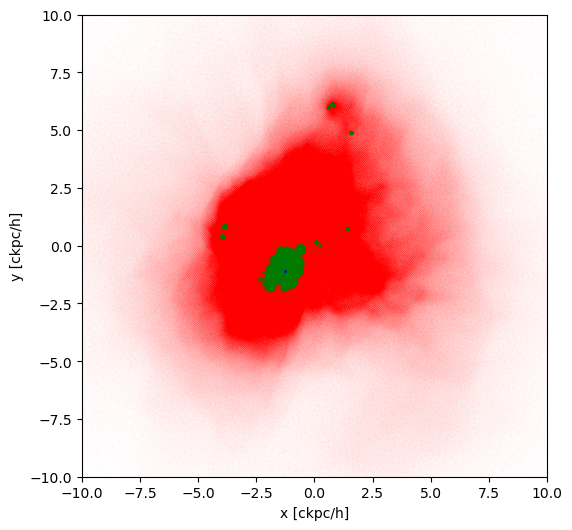

In [28]:
x_lim = y_lim = 10

plt.figure( figsize=(6,6) )
plt.scatter( coord[:,0] / (scale_factor * unit_length_cgs), coord[:,1] / (scale_factor * unit_length_cgs), s=0.00001, c='r' )
plt.scatter( coord_over[:,0] / (scale_factor * unit_length_cgs), coord_over[:,1] / (scale_factor * unit_length_cgs), s=0.01, c='g' )
plt.scatter( COM[0] / (scale_factor * unit_length_cgs), COM[1] / (scale_factor * unit_length_cgs), s=1, c='b' )
# plt.scatter( coord_in_1[:,0] / (scale_factor * unit_length_cgs), coord_in_1[:,1] / (scale_factor * unit_length_cgs), s=0.01, c='b' )
plt.xlim( -x_lim, x_lim )
plt.ylim( -y_lim, y_lim )

plt.xlabel('x [ckpc/h]')
plt.ylabel('y [ckpc/h]')

plt.show()

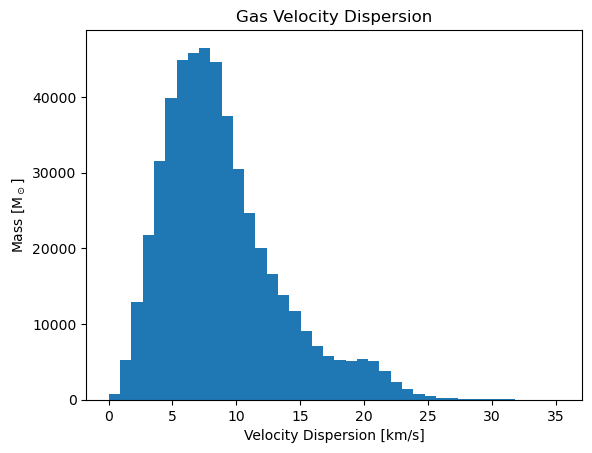

In [12]:
plt.hist( velocity_fluctuation_magnitudes / 100000, bins=40, weights=masses/unit_mass_cgs*1e10 )

plt.title('Gas Velocity Dispersion')
plt.xlabel('Velocity Dispersion [km/s]')
plt.ylabel('Mass [M$_\odot$]')

plt.show()

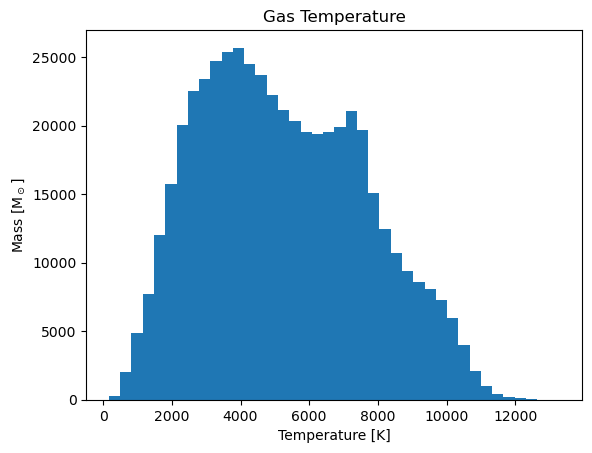

In [23]:
plt.hist( gas_temp[ind_1], bins=40, weights=masses/unit_mass_cgs*1e10 )

plt.title('Gas Temperature')
plt.xlabel('Temperature [K]')
plt.ylabel('Mass [M$_\odot$]')

plt.show()

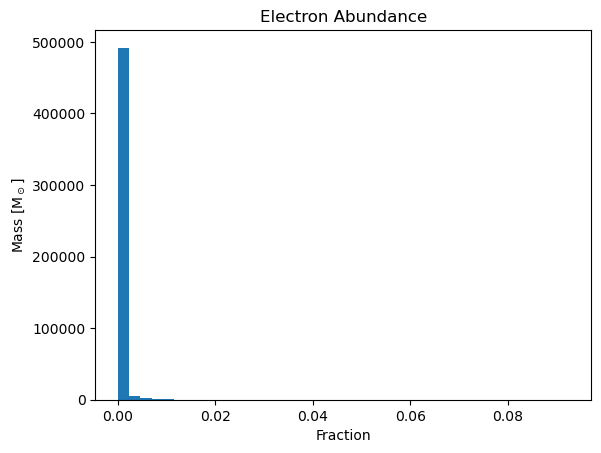

In [38]:
plt.hist( f['PartType0']['ElectronAbundance'][:][ind_1], bins=40, weights=masses/unit_mass_cgs*1e10 )

plt.title('Electron Abundance')
plt.xlabel('Fraction')
plt.ylabel('Mass [M$_\odot$]')

plt.show()

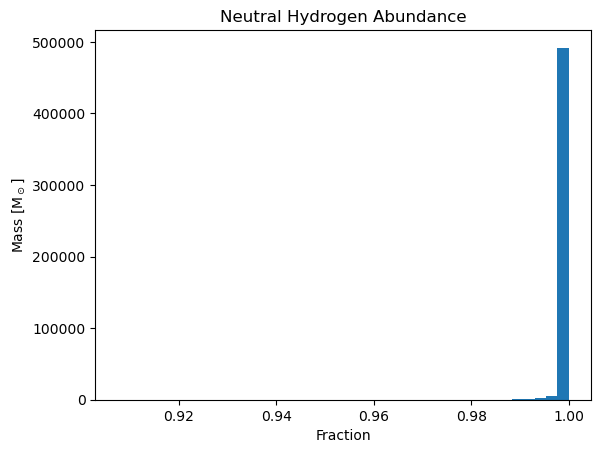

In [39]:
plt.hist( f['PartType0']['NeutralHydrogenAbundance'][:][ind_1], bins=40, weights=masses/unit_mass_cgs*1e10 )

plt.title('Neutral Hydrogen Abundance')
plt.xlabel('Fraction')
plt.ylabel('Mass [M$_\odot$]')

plt.show()

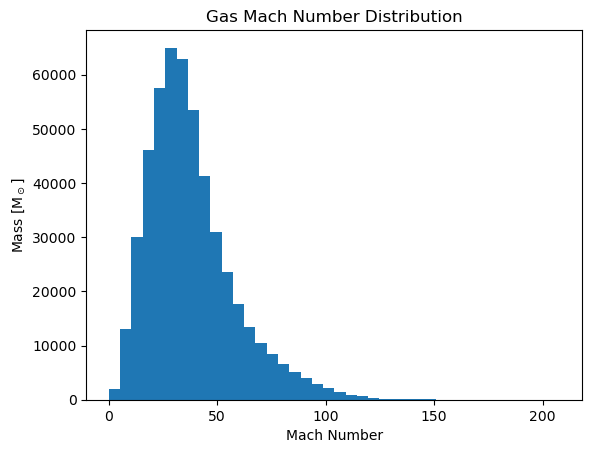

In [32]:
# Constants for air
gamma = 5/3  # Adiabatic index for idea gas
R = 8.31  # Specific gas constant for ISM in J/mol·K
m = 1  # Molar mass of ISM in g/mol

# Given temperature
T = gas_temp[ind_1]  # in Kelvin

# Calculate the speed of sound in the medium
speed_of_sound = np.sqrt(gamma * R * T / m) * 100

# Calculate the magnitude of the velocity for each particle
velocity_magnitude = np.sqrt(np.sum(velocity_data**2, axis=1))

# Calculate the Mach number for each particle
mach_numbers = velocity_magnitude / speed_of_sound

# Display the speed of sound and first few Mach numbers
speed_of_sound, np.std(mach_numbers)

plt.hist( mach_numbers, bins=40, weights=masses/unit_mass_cgs*1e10 )

plt.title('Gas Mach Number Distribution')
plt.xlabel('Mach Number')
plt.ylabel('Mass [M$_\odot$]')

plt.show()

In [30]:
speed_of_sound

array([37657.57 , 33829.473, 36850.38 , ..., 24159.127, 24224.955,
       24774.205], dtype=float32)

In [17]:
speed_of_sound

array([202830.08 , 182211.3  , 198482.4  , ..., 130125.16 , 130479.734,
       133438.1  ], dtype=float32)

In [10]:
total_energy        = []
potential_energy    = []
kinetic_energy      = []
internel_energy     = []
total_mass          = []
gas_mass_set        = []

# Do at the very first
gas_ind = np.where( gas_distance < distance[0] * scale_factor * unit_length_cgs )[0]
dm_ind  = np.where( dm_distance < distance[0] * scale_factor * unit_length_cgs )[0]
total_mass.append( np.sum( gas_mass[gas_ind] ) + np.sum( dm_mass[dm_ind]) )
gas_mass_set.append( np.sum( gas_mass[gas_ind] ) )

for d in distance[1:]:
    d *= (scale_factor * unit_length_cgs)
    # Find the gas and dm particles within the distance
    gas_ind = np.where( gas_distance < d )[0]
    dm_ind  = np.where( dm_distance < d )[0]

    total_mass.append( np.sum( gas_mass[gas_ind] ) + np.sum( dm_mass[dm_ind] ) )
    gas_mass_set.append( np.sum( gas_mass[gas_ind] ) )

    # Calculate the potential_energy
    P = np.sum( gas_potent[gas_ind]*mass[gas_ind] )
    potential_energy.append(P)

    # Calculate the kinetic_energy
    # Calculate the velocity of the center of mass
    com_vx = np.sum( gas_mass[gas_ind] * gas_vel[gas_ind,0] ) / np.sum( gas_mass[gas_ind] )
    com_vy = np.sum( gas_mass[gas_ind] * gas_vel[gas_ind,1] ) / np.sum( gas_mass[gas_ind] )
    com_vz = np.sum( gas_mass[gas_ind] * gas_vel[gas_ind,2] ) / np.sum( gas_mass[gas_ind] )

    rel_vx, rel_vy, rel_vz = gas_vel[:,0] - com_vx, gas_vel[:,1] - com_vy, gas_vel[:,2] - com_vz
    rel_v = np.sqrt(rel_vx**2 + rel_vy**2 + rel_vz**2)
    Ek = np.sum(1/2*mass[gas_ind]*rel_v[gas_ind]**2)

    # Calculate the internel_energy
    Eu = np.sum( gas_intern[gas_ind] * mass[gas_ind] )

    # Use the above values to obtain the total energy
    E = -P + Ek + Eu

    # Record the value across snapshots
    total_energy.append(E)
    potential_energy.append(P)
    kinetic_energy.append(-Ek/P)
    internel_energy.append(-Eu/P)

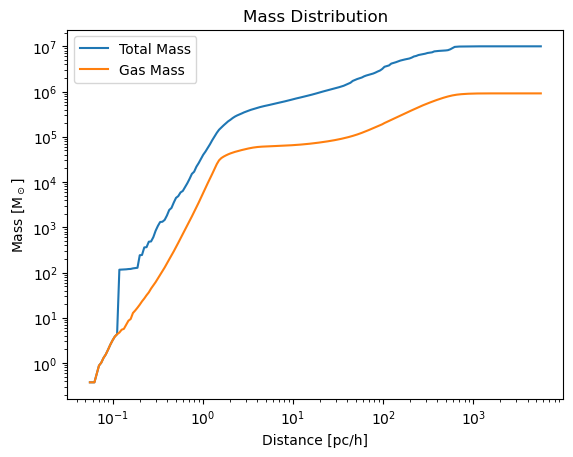

In [11]:
plt.plot( distance * scale_factor * 1000, total_mass/unit_mass_cgs*1e10, label='Total Mass')
plt.plot( distance * scale_factor * 1000, gas_mass_set/unit_mass_cgs*1e10, label='Gas Mass')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Distance [pc/h]')
plt.ylabel('Mass [M$_\odot$]')
plt.title('Mass Distribution')
plt.legend()

plt.show()

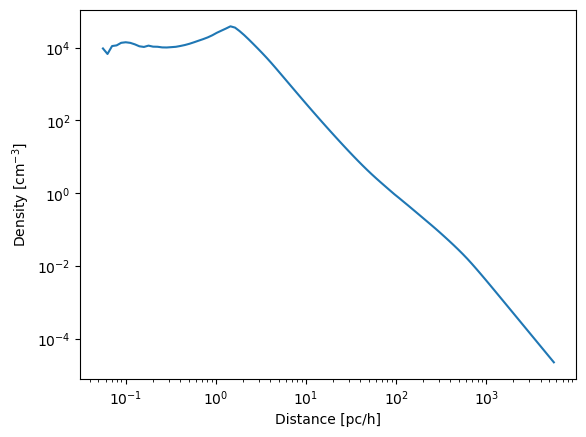

In [83]:
plt.plot( distance * scale_factor * 1000, gas_mass_set / (4/3 * np.pi * (distance*scale_factor*unit_length_cgs)**3) * 6e23 ) 
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Distance [pc/h]')
plt.ylabel('Density [cm$^{-3}$]')

plt.show()

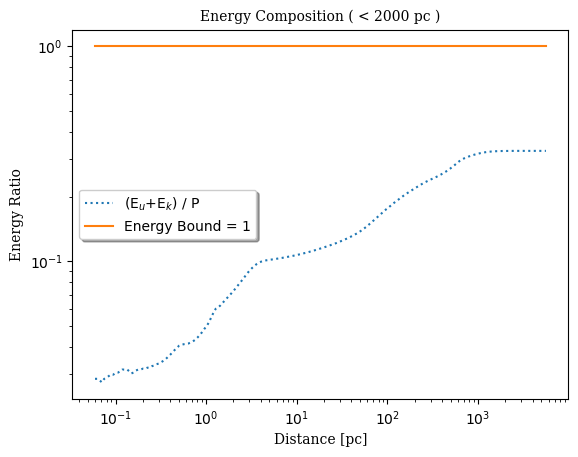

In [71]:
# Plot the energy profile
fig, ax = plt.subplots()
ax.plot(distance[1:]* scale_factor * 1000, np.array(kinetic_energy) + np.array(internel_energy)    , ':'   , label='(E$_u$+E$_k$) / P')
ax.plot(distance[1:]* scale_factor * 1000, [1]*len(internel_energy), label='Energy Bound = 1' )

legend = ax.legend(loc=6, shadow=True)

plt.yscale('log')
plt.xscale('log')
# plt.ylim(0.1, 10)
plt.xlabel('Distance [pc]', fontdict=font)
plt.ylabel('Energy Ratio', fontdict=font)

plt.title('Energy Composition ( < 2000 pc )', fontdict=font)
plt.show()

In [11]:
bbox = [[-30.0, 30.0], [-30.0, 30.0], [-30.0, 30.0]]

unit_base = {
    "length": (1000, "pc"),
    "velocity": (1.0, "km/s"),
    "mass": (1e10, "Msun"),
}

ds = yt.load("./snapshot_%03d.hdf5" % (N_s), unit_base=unit_base, bounding_box=bbox)

yt : [INFO     ] 2024-05-10 15:28:54,597 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2024-05-10 15:28:54,634 Parameters: current_time              = 0.05608886177344292
yt : [INFO     ] 2024-05-10 15:28:54,634 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-05-10 15:28:54,634 Parameters: domain_left_edge          = [-30. -30. -30.]
yt : [INFO     ] 2024-05-10 15:28:54,635 Parameters: domain_right_edge         = [30. 30. 30.]
yt : [INFO     ] 2024-05-10 15:28:54,635 Parameters: cosmological_simulation   = 0
yt : [WARNING  ] 2024-05-10 15:28:54,636 A bounding box was explicitly specified, so we are disabling periodicity.


yt : [INFO     ] 2024-05-10 01:49:34,784 Allocating for 6.636e+06 particles
Initializing coarse index : 100%|██████████| 25/25 [00:00<00:00, 35.84it/s]
yt : [INFO     ] 2024-05-10 01:49:35,501 Updating index_order2 from 2 to 2
Initializing refined index: 100%|██████████| 25/25 [00:03<00:00,  8.17it/s]
Interpolating SPH field ('PartType0', 'Density'): 15000000it [00:14, 1009786.99it/s]
Interpolating SPH field ('PartType0', 'particle_velocity_x'): 15000000it [00:15, 980208.68it/s] 
Interpolating SPH field ('PartType0', 'Density'): 15000000it [00:14, 1004012.82it/s]
Interpolating SPH field ('PartType0', 'particle_velocity_y'): 15000000it [00:15, 938922.44it/s] 
Interpolating SPH field ('PartType0', 'Density'): 15000000it [00:14, 1011239.23it/s]
Interpolating SPH field ('PartType0', 'particle_velocity_z'): 15000000it [00:16, 927151.58it/s] 


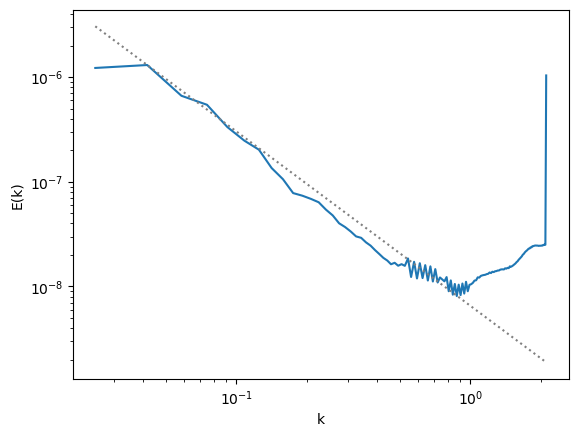

In [102]:
def doit(ds):
    # a FFT operates on uniformly gridded data.  We'll use the yt
    # covering grid for this.

    max_level = 8

    # ref = int(np.prod(ds.ref_factors[0:max_level]))

    low = ds.domain_left_edge
    dims = 2**max_level

    nx = ny = nz = dims

    nindex_rho = 1.0 / 3.0

    Kk = np.zeros((nx // 2 + 1, ny // 2 + 1, nz // 2 + 1))

    for vel in [("gas", "velocity_x"), ("gas", "velocity_y"), ("gas", "velocity_z")]:
        Kk += 0.5 * fft_comp(
            ds, ("gas", "density"), vel, nindex_rho, max_level, low, dims
        )

    # wavenumbers
    L = (ds.domain_right_edge - ds.domain_left_edge).d

    kx = np.fft.rfftfreq(nx) * nx / L[0]
    ky = np.fft.rfftfreq(ny) * ny / L[1]
    kz = np.fft.rfftfreq(nz) * nz / L[2]

    # physical limits to the wavenumbers
    kmin = np.min(1.0 / L)
    kmax = np.min(0.5 * dims / L)

    kbins = np.arange(kmin, kmax, kmin)
    N = np.shape(kbins)[0]

    # bin the Fourier KE into radial kbins
    kx3d, ky3d, kz3d = np.meshgrid(kx, ky, kz, indexing="ij")
    k = np.sqrt(kx3d**2 + ky3d**2 + kz3d**2)

    whichbin = np.digitize(k.flat, kbins)
    ncount = np.bincount(whichbin)
    
    E_spectrum = np.zeros(np.shape(ncount)[0] - 1)

    for n in range(1, np.shape(ncount)[0]):
        E_spectrum[n - 1] = np.sum(Kk.flat[whichbin == n])

    k = 0.5 * (kbins[0 : N - 1] + kbins[1:N])
    E_spectrum = E_spectrum[1:N]

    index = np.argmax(E_spectrum)
    kmax = k[index]
    Emax = E_spectrum[index]

    plt.loglog(k, E_spectrum / kmin)
    plt.loglog(k, Emax * (k / kmax) ** (-5.0 / 3.0) / kmin, ls=":", color="0.5")

    plt.xlabel(r"k")
    plt.ylabel(r"E(k)")

    plt.savefig("spectrum.png")


def fft_comp(ds, irho, iu, nindex_rho, level, low, delta):
    cube = ds.covering_grid(level, left_edge=low, dims=delta, fields=[irho, iu])

    rho = cube[irho].d
    u = cube[iu].d

    nx, ny, nz = rho.shape

    # do the FFTs -- note that since our data is real, there will be
    # too much information here.  fftn puts the positive freq terms in
    # the first half of the axes -- that's what we keep.  Our
    # normalization has an '8' to account for this clipping to one
    # octant.
    ru = np.fft.fftn(rho**nindex_rho * u)[
        0 : nx // 2 + 1, 0 : ny // 2 + 1, 0 : nz // 2 + 1
    ]
    ru = 8.0 * ru / (nx * ny * nz)

    return np.abs(ru) ** 2


doit(ds)

In [30]:
COM / (scale_factor * unit_length_cgs)

array([-1.25951134, -1.11266036,  1.78459686])

In [34]:
len =  20 * scale_factor * unit_length_cgs / 3.08e21
CM = COM / (scale_factor * unit_length_cgs)

bbox = [[-len + CM[0], len + CM[0]], [-len + CM[1], len + CM[1]], [-len + CM[2], len + CM[2]]]
unit_base = {
    "length": (scale_factor * unit_length_cgs / 3.08e21, "kpc"),
    "velocity": (1.0, "km/s"),
    "mass": (unit_mass_cgs / 1.933e33, "Msun"),
}

ds = yt.load("./snapshot_%03d.hdf5" % (N_s), unit_base=unit_base, bounding_box=bbox)
# ds.force_periodicity()

yt : [INFO     ] 2024-05-11 02:24:26,732 Omega Lambda is 0.0, so we are turning off Cosmology.
yt : [INFO     ] 2024-05-11 02:24:26,759 Parameters: current_time              = 0.05608886177344292
yt : [INFO     ] 2024-05-11 02:24:26,759 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-05-11 02:24:26,760 Parameters: domain_left_edge          = [-2.91856838 -2.7717174   0.12553982]
yt : [INFO     ] 2024-05-11 02:24:26,760 Parameters: domain_right_edge         = [0.3995457  0.54639668 3.4436539 ]
yt : [INFO     ] 2024-05-11 02:24:26,760 Parameters: cosmological_simulation   = 0
yt : [WARNING  ] 2024-05-11 02:24:26,761 A bounding box was explicitly specified, so we are disabling periodicity.


In [20]:
cube = ds.covering_grid(8, left_edge=ds.domain_left_edge, dims=2**8, fields=("gas", "density"))

yt : [INFO     ] 2024-05-10 16:26:52,819 Allocating for 6.636e+06 particles


Initializing coarse index : 100%|██████████| 25/25 [00:00<00:00, 64.76it/s]
yt : [INFO     ] 2024-05-10 16:26:53,217 Updating index_order2 from 2 to 2
Initializing refined index: 100%|██████████| 25/25 [00:02<00:00, 11.86it/s]
Interpolating SPH field ('PartType0', 'Density'): 4500000it [00:24, 183381.58it/s]


In [21]:
fn = cube.save_as_dataset(fields=[("deposit", "nbody_density")])

yt : [INFO     ] 2024-05-10 16:28:06,644 Saving field data to yt dataset: snapshot_158_covering_grid.h5.


In [22]:
ds_grid = yt.load(fn)
p = yt.ProjectionPlot(ds_grid, [1, 1, 1], ("grid", "nbody_density"))
p.save()

yt : [INFO     ] 2024-05-10 16:28:07,301 Parameters: current_time              = 0.05608886177344292 code_time
yt : [INFO     ] 2024-05-10 16:28:07,302 Parameters: domain_dimensions         = [256 256 256] dimensionless
yt : [INFO     ] 2024-05-10 16:28:07,302 Parameters: domain_left_edge          = [-2.92425241 -2.74676353  0.07581071] code_length
yt : [INFO     ] 2024-05-10 16:28:07,303 Parameters: domain_right_edge         = [0.39386167 0.57135055 3.39392479] code_length


yt : [INFO     ] 2024-05-10 16:28:07,303 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-05-10 16:28:07,372 xlim = -1.659057 1.659057
yt : [INFO     ] 2024-05-10 16:28:07,372 ylim = -1.659057 1.659057
yt : [INFO     ] 2024-05-10 16:28:07,372 zlim = -1.659057 1.659057
yt : [INFO     ] 2024-05-10 16:28:07,374 Making a fixed resolution buffer of (('grid', 'nbody_density')) 800 by 800
yt : [INFO     ] 2024-05-10 16:28:12,059 Saving plot snapshot_158_covering_grid.h5_OffAxisProjection_nbody_density.png


['snapshot_158_covering_grid.h5_OffAxisProjection_nbody_density.png']

Interpolating SPH field ('PartType0', 'Density'): 250000it [00:07, 32856.48it/s] 
Interpolating SPH field ('PartType0', 'Density'): 8200000it [03:28, 39242.42it/s] 
Interpolating SPH field ('PartType0', 'particle_velocity_x'): 8200000it [03:25, 39864.43it/s] 
Interpolating SPH field ('PartType0', 'Density'): 8200000it [03:20, 40972.68it/s] 
Interpolating SPH field ('PartType0', 'particle_velocity_y'): 8200000it [03:20, 40798.34it/s] 
Interpolating SPH field ('PartType0', 'Density'): 8200000it [03:20, 40835.81it/s]
Interpolating SPH field ('PartType0', 'particle_velocity_z'): 8200000it [03:20, 40899.66it/s] 


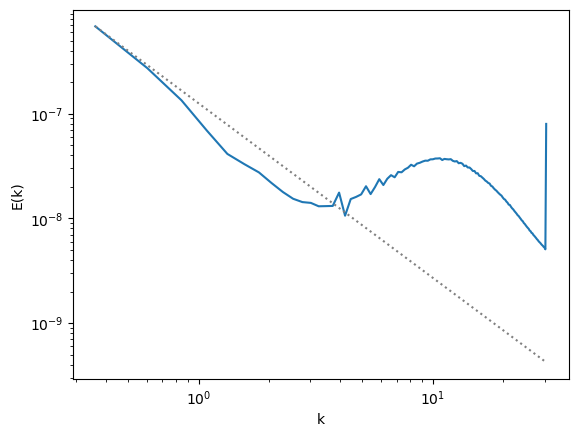

In [99]:

def fft_comp(ds, irho, iu, nindex_rho, level, low, delta):
    cube = ds.covering_grid(level, left_edge=low, dims=delta, fields=[irho, iu])

    rho = cube[irho].d
    u = cube[iu].d

    nx, ny, nz = rho.shape

    # do the FFTs -- note that since our data is real, there will be
    # too much information here.  fftn puts the positive freq terms in
    # the first half of the axes -- that's what we keep.  Our
    # normalization has an '8' to account for this clipping to one
    # octant.
    ru = np.fft.fftn(rho**nindex_rho * u)[
        0 : nx // 2 + 1, 0 : ny // 2 + 1, 0 : nz // 2 + 1
    ]
    ru = 8.0 * ru / (nx * ny * nz)

    return np.abs(ru) ** 2


# a FFT operates on uniformly gridded data.  We'll use the yt
# covering grid for this.

max_level = 8

# ref = int(np.prod(ds.ref_factors[0:max_level]))

low = ds.domain_left_edge
dims = 2**max_level

nx = ny = nz = dims

nindex_rho = 1.0 / 3.0

Kk = np.zeros((nx // 2 + 1, ny // 2 + 1, nz // 2 + 1))

for vel in [("gas", "velocity_x"), ("gas", "velocity_y"), ("gas", "velocity_z")]:
    Kk += 0.5 * fft_comp(
        ds, ("gas", "density"), vel, nindex_rho, max_level, low, dims
    )

# wavenumbers
L = (ds.domain_right_edge - ds.domain_left_edge).d

kx = np.fft.rfftfreq(nx) * nx / L[0]
ky = np.fft.rfftfreq(ny) * ny / L[1]
kz = np.fft.rfftfreq(nz) * nz / L[2]

# physical limits to the wavenumbers
kmin = np.min(1.0 / L)
kmax = np.min(0.5 * dims / L)

kbins = np.arange(kmin, kmax, kmin)
N = np.shape(kbins)[0]

# bin the Fourier KE into radial kbins
kx3d, ky3d, kz3d = np.meshgrid(kx, ky, kz, indexing="ij")
k = np.sqrt(kx3d**2 + ky3d**2 + kz3d**2)

whichbin = np.digitize(k.flat, kbins)
ncount = np.bincount(whichbin)

E_spectrum = np.zeros(np.shape(ncount)[0] - 1)

for n in range(1, np.shape(ncount)[0]):
    E_spectrum[n - 1] = np.sum(Kk.flat[whichbin == n])

k = 0.5 * (kbins[0 : N - 1] + kbins[1:N])
E_spectrum = E_spectrum[1:N]

index = np.argmax(E_spectrum)
kmax = k[index]
Emax = E_spectrum[index]

plt.loglog(k, E_spectrum / kmin)
plt.loglog(k, Emax * (k / kmax) ** (-5.0 / 3.0) / kmin, ls=":", color="0.5")

plt.xlabel(r"k")
plt.ylabel(r"E(k)")

plt.savefig("spectrum.png")

yt : [INFO     ] 2024-05-10 09:45:03,993 xlim = -30.000000 30.000000
yt : [INFO     ] 2024-05-10 09:45:03,995 ylim = -30.000000 30.000000
yt : [INFO     ] 2024-05-10 09:45:03,996 xlim = -30.000000 30.000000
yt : [INFO     ] 2024-05-10 09:45:03,996 ylim = -30.000000 30.000000
yt : [INFO     ] 2024-05-10 09:45:04,001 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



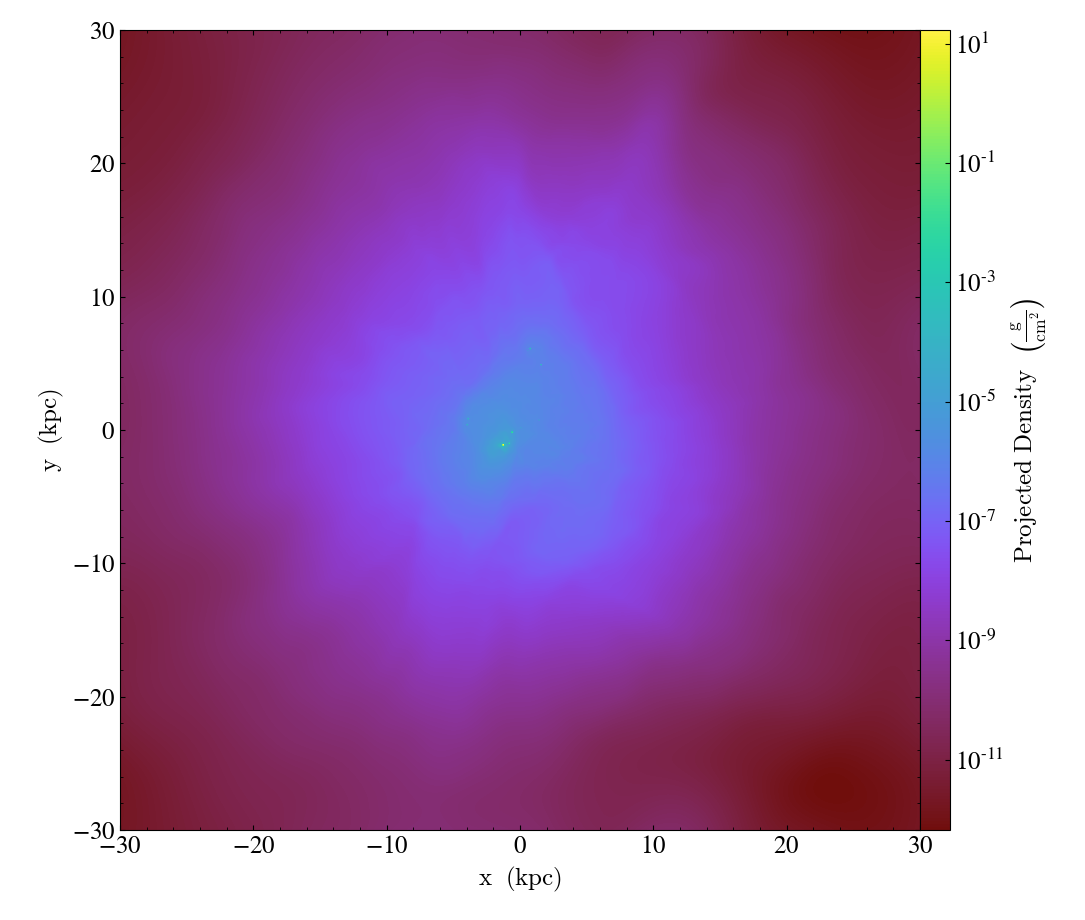

In [103]:

ad = ds.all_data()

px = yt.ProjectionPlot(ds, "z", ("gas", "density"))
px.show()

In [ ]:
from yt.units import kpc

prj = yt.ProjectionPlot(
    ds,
    "x",
    ("gas", "density"),
    center = ( -1.25040974, -1.11096276,  1.76063138),
    width = 0.2 * kpc,
    weight_field=("gas", "density"),
    buff_size=(1000, 1000),
)
zmin = 1e-27
zmax = 5e-20
# Set the colorbar limits
prj.set_zlim(("gas", "density"), zmin, zmax)
prj.set_colorbar_label(("gas", "density"), "Projected Density (g/ccm$^{2}$)")
prj.set_xlabel("y [ckpc/h]")
prj.set_ylabel("z [ckpc/h]")

prj.set_cmap(field=("gas", "density"), cmap="RED TEMPERATURE")
prj.annotate_streamlines(("gas", "velocity_x"), ("gas", "velocity_y"))

prj.save()

In [11]:
ad = ds.all_data()
print(dir(ds.fields))
print(dir(ds.fields.gas))

yt : [INFO     ] 2024-05-07 00:56:34,911 Allocating for 6.636e+06 particles
Initializing coarse index :   0%|          | 0/25 [00:00<?, ?it/s]

Initializing coarse index : 100%|██████████| 25/25 [00:00<00:00, 43.06it/s]
yt : [INFO     ] 2024-05-07 00:56:35,502 Updating index_order2 from 2 to 2
Initializing refined index: 100%|██████████| 25/25 [00:03<00:00,  8.18it/s]


['PartType0', 'PartType1', 'all', 'deposit', 'gas', 'index', 'nbody']
['angular_momentum', 'angular_momentum_magnitude', 'angular_momentum_x', 'angular_momentum_y', 'angular_momentum_z', 'cutting_plane_velocity_x', 'cutting_plane_velocity_y', 'cutting_plane_velocity_z', 'cylindrical_radius', 'cylindrical_theta', 'cylindrical_z', 'density', 'dynamical_time', 'four_velocity_magnitude', 'four_velocity_t', 'four_velocity_x', 'four_velocity_y', 'four_velocity_z', 'index', 'jeans_mass', 'kT', 'kinetic_energy_density', 'lorentz_factor', 'mass', 'mean_molecular_weight', 'momentum_density_x', 'momentum_density_y', 'momentum_density_z', 'momentum_x', 'momentum_y', 'momentum_z', 'number_density', 'ones', 'position', 'radial_velocity', 'radial_velocity_absolute', 'radius', 'relative_velocity_x', 'relative_velocity_y', 'relative_velocity_z', 'relative_x', 'relative_y', 'relative_z', 'smoothing_length', 'specific_angular_momentum', 'specific_angular_momentum_magnitude', 'specific_angular_momentum_x'

In [ ]:
f1 = h5py.File("snapshot_%03d.hdf5" % i, 'r')
f2 = h5py.File("../TNG/subhalo27075/snapshot_%03d.hdf5" % i, 'r')
f3 = h5py.File("../TNG/subhalo27075/res_1/snapshot_%03d.hdf5" % i, 'r')
f4 = h5py.File("../TNG/subhalo27075/res_1e2/snapshot_%03d.hdf5" % i, 'r')

Time = 1/f1['Header'].attrs['Time'] - 1

# Calculate the mass in each shell
beams = 200
density_set = []

_, bin_edges = Density_In_Beams( f1, beams )

density_set.append( Density_In_Beams( f1, beams )[0] )
density_set.append( Density_In_Beams( f2, beams )[0] )
density_set.append( Density_In_Beams( f3, beams )[0] )
density_set.append( Density_In_Beams( f4, beams )[0] )

# Plot the figure
plt.figure( figsize=(8, 6), dpi= 100 )

plt.plot( bin_edges[:beams], density_set[0] , label='%9.1f M$_\odot$' % 0.1 )
plt.plot( bin_edges[:beams], density_set[1] , '--', color='orange', label='%9.1f M$_\odot$' % 1 )
plt.plot( bin_edges[:beams], density_set[2] , '-.', color='green', label='%8.1f M$_\odot$' % 10 )
plt.plot( bin_edges[:beams], density_set[3] , '-.', color='red', label='%7.1f M$_\odot$' % 100 )
plt.xscale('log')
plt.yscale('log')

plt.ylim( 1e-6, 1)

plt.legend( prop=font, title='Resolution' )

plt.xlabel('Density [cm$^{-3}]$', fontdict=font)
plt.ylabel('Mass Fraction', fontdict=font)
plt.title('Density Distribution at z ~ %.2f' % Time, fontdict=font)

# plt.show()
plt.savefig('convergence_%03d.png' % i)
plt.close()

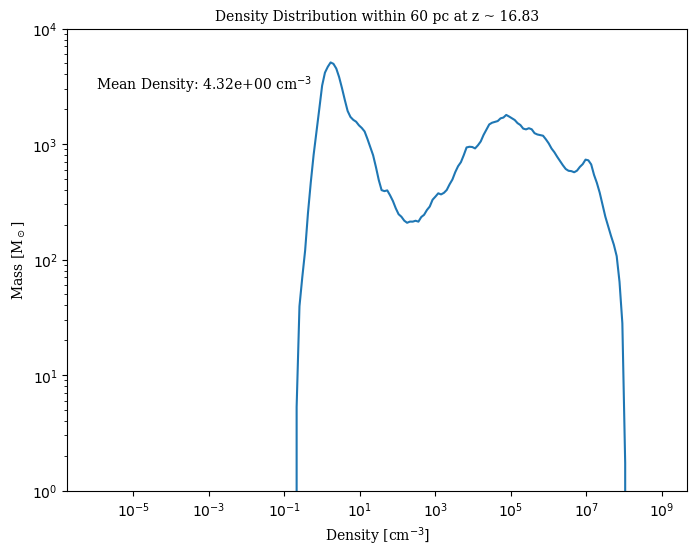

In [117]:
# Calculate the mass in each shell
beams = 200

fraction, bin_edges = Density_In_Beams( mass_in_1, density[ind_1], beams, 1 )
# fraction, bin_edges = Density_In_Beams( mass, density, beams, 1 )

# Calculate the mean density of the snapshot

mean_density = np.sum(mass_in_1) / (4/3 * np.pi * (1 * scale_factor * unit_length_cgs)**3) / Number_Density_Fraction

# Plot the figure
plt.figure( figsize=(8, 6), dpi= 100 )

plt.plot( bin_edges[0:beams], fraction*np.sum(mass_in_1) / unit_mass_cgs * 1e10, label='%9.1f M$_\odot$' % 0.1 )
# plt.plot( bin_edges[0:beams], fraction*np.sum(mass), label='%9.1f M$_\odot$' % 0.1 )
plt.xscale('log')
plt.yscale('log')
plt.ylim( 1, 1e4)

plt.text( 1e-6, 3e3, 'Mean Density: %.2e cm$^{-3}$' % mean_density, fontdict=font )

plt.xlabel('Density [cm$^{-3}]$', fontdict=font)
plt.ylabel('Mass [M$_\odot$]', fontdict=font)
plt.title('Density Distribution within 60 pc at z ~ %.2f' % time, fontdict=font)

plt.show()

In [89]:
mean_density = np.sum(mass_in_5) / (4/3 * np.pi * (2.5 * scale_factor * unit_length_cgs)**3) / Number_Density_Fraction
std_density = np.std(density[ind_5] / Number_Density_Fraction)

In [90]:
mean_density, std_density

(0.6207596925127954, 3579497.0149963126)

In [ ]:
# Calculate the spin parameter across all snapshots

spin_set = []
r_half_set = []
time_set = []

for i in range(N_i, N_f):
    # Constants
    G = 6.67430e-11         # Gravitational constant in m^3 kg^-1 s^-2
    G = G * (100)**3 / 1000 # to cgs

    f = h5py.File( "snapshot_%03d.hdf5" % i )

    scale_factor        = f['Header'].attrs['Time']
    h_factor            = f['Header'].attrs['HubbleParam']
    unit_length_cgs     = f['Header'].attrs['UnitLength_In_CGS']
    unit_mass_cgs       = f['Header'].attrs['UnitMass_In_CGS']
    unit_vel_cgs        = f['Header'].attrs['UnitVelocity_In_CGS']

    gas_coord   = f['PartType0']['Coordinates'][:] 
    gas_vel     = f['PartType0']['Velocities'][:]
    gas_mass    = f['PartType0']['Masses'][:]
    gas_density = f['PartType0']['Density'][:]

    coord   = gas_coord * scale_factor * unit_length_cgs
    vel     = gas_vel * np.sqrt(scale_factor) * unit_vel_cgs
    mass    = gas_mass * unit_mass_cgs
    density = gas_density * unit_mass_cgs / (unit_length_cgs * scale_factor)**3

    # Example particle data (replace with your data)
    x, y, z = coord[:,0], coord[:,1], coord[:,2]
    vx, vy, vz = vel[:,0], vel[:,1], vel[:,2]

    # num_bins = 100
    # mass_in_shells, shell_volumes, bins = Mass_Shells( coord, mass, num_bins )

    # Total mass
    M = np.sum(mass)

    # Center of mass
    CM_x = np.sum(x * mass) / M
    CM_y = np.sum(y * mass) / M
    CM_z = np.sum(z * mass) / M

    # Position and velocity relative to center of mass
    rel_x = x - CM_x
    rel_y = y - CM_y
    rel_z = z - CM_z
    rel_vx = vx - np.mean(vx)
    rel_vy = vy - np.mean(vy)
    rel_vz = vz - np.mean(vz)

    # Angular momentum for each particle
    lx = rel_y * rel_vz - rel_z * rel_vy
    ly = rel_z * rel_vx - rel_x * rel_vz
    lz = rel_x * rel_vy - rel_y * rel_vx

    # Total angular momentum
    Lx = np.sum(lx * mass)
    Ly = np.sum(ly * mass)
    Lz = np.sum(lz * mass)
    L = np.sqrt(Lx**2 + Ly**2 + Lz**2)

    # Assuming you have the virial radius R
    # R = half_mass_radius( mass_in_shells, num_bins, bins )
    halo_mass = M + np.sum( f['PartType1']['Masses'][:] ) * unit_mass_cgs
    R = Virial_Radius( halo_mass, 1/scale_factor-1 )

    # Circular velocity at R
    V = np.sqrt(G * M / R)

    # Spin parameter
    lambda_spin = L / (np.sqrt(2) * M * R * V)

    spin_set.append( lambda_spin )
    r_half_set.append( R / 3.08e21 )
    time_set.append( 1/scale_factor - 1 )

In [ ]:
fig, ax1 = plt.subplots()

# ax2 = ax1.twinx()
ax1.plot( time_set , spin_set, 'g-' )
ax1.invert_xaxis()
# ax2.plot( time_set , np.array(r_half_set) / 3.08e21, 'b-' )
# ax2.invert_xaxis()

ax1.set_xlabel('Redshift', fontdict=font)
ax1.set_ylabel('Spin parameter', color='g', fontdict=font)
# ax2.set_ylabel('Virial radius [kpc]', color='b')

plt.title('Spin Parameter', fontdict=font)
plt.show()

In [10]:
# Calculate the divergence and the curl of particles

import numpy as np
from scipy.spatial import cKDTree

# Define the SPH kernel function
def kernel_function(q):
    if 0 <= q < 1:
        return 1 / ( 4 * np.pi ) * ((2 - q) ** 3 - 4 * (1 - q) ** 3)
    elif 1 <= q < 2:
        return 1 / ( 4 * np.pi ) * (2 - q) ** 3
    else:
        return 0

# Find the particles ind inside 5 ckpc
gas_ind = np.where( gas_distance < 4*scale_factor*unit_length_cgs )[0]

# Define the particle positions and velocities
x, y, z = gas_coord[gas_ind, 0], gas_coord[gas_ind, 1], gas_coord[gas_ind, 2]
vx, vy, vz = gas_vel[gas_ind, 0], gas_vel[gas_ind, 1], gas_vel[gas_ind, 2]

# Define the smoothing length
h = f['PartType0']['AGS-Softening'][:][gas_ind] * scale_factor * unit_length_cgs

# Create a KDTree for efficient neighbor search
tree = cKDTree(np.column_stack([x, y, z]))

# Calculate the divergence and curl
div_v = np.zeros_like(x)
curl_v = np.zeros((np.shape(x)[0], 3))

# Find neighbors within smoothing length for all particles
for i in range(np.shape(x)[0]):
    # Find the neighbors within the smoothing length
    ix = tree.query_ball_point([x[i], y[i], z[i]], h[i])
    # Calculate the differences in position and velocity
    dx = x[ix] - x[i]
    dy = y[ix] - y[i]
    dz = z[ix] - z[i] 
    dvx = vx[ix] - vx[i]
    dvy = vy[ix] - vy[i]
    dvz = vz[ix] - vz[i]

    x_set = np.array( [dx, dy, dz] ).T
    v_set = np.array( [dvx, dvy, dvz] ).T
    
    # Calculate the weights using the SPH cubic spline kernel
    q = np.sqrt(dx**2 + dy**2 + dz**2) / h[i]
    w = np.zeros_like(q)
    for j, jq in enumerate( q ):
        w[j] = kernel_function(jq)
    
    # # Calculate the divergence and curl
    div_v[i]    = np.sum(np.dot( w, x_set * v_set )) / h[i]**3
    curl_v[i]   = np.sum(np.dot( w, np.cross(x_set, v_set) ), axis=0) / h[i]**3

KeyboardInterrupt: 

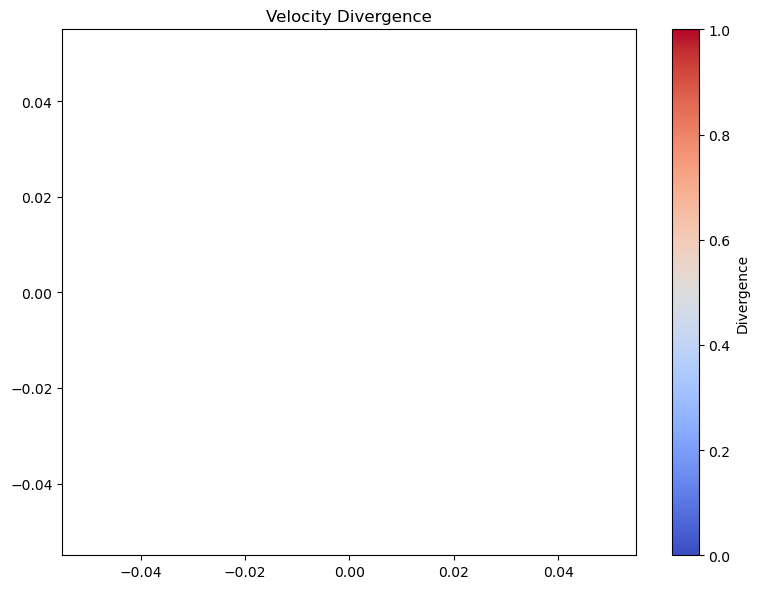

In [15]:
# Visualize the divergence and curl
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.scatter(x / (scale_factor*unit_length_cgs), y / (scale_factor*unit_length_cgs), c=div_v, cmap='coolwarm', s=0.01)
plt.colorbar(label='Divergence')
plt.title('Velocity Divergence')

plt.tight_layout()
plt.show()